<a href="https://colab.research.google.com/github/buddhini81/mlexercises/blob/main/CreditRiskAssessment_DecisionTreeClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 1. Data Loading and Cleaning

In [4]:
from google.colab import files
uploaded = files.upload()

Saving credit_risk_dataset.csv to credit_risk_dataset.csv


In [5]:

# Loads the dataset into a Pandas DataFrame.
df = pd.read_csv("credit_risk_dataset.csv")

# Filters out an extreme outliers in the person_age column (value 123, 144 ...etc.), which can skew model training.
df_clean = df[df['person_age'] < 100].copy()

# Drop the 'ID' column if it exists, as it's not a predictor.
if 'ID' in df_clean.columns:
    df_clean = df_clean.drop('ID', axis=1)

# Define the target variable (y) and features (X)
TARGET_COLUMN = 'loan_status'
y = df_clean[TARGET_COLUMN]
X = df_clean.drop(TARGET_COLUMN, axis=1)

# Separates the column names into two lists based on their data type, which is necessary for tailored preprocessing.
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


# 2. Preprocessing Pipeline Setup

In [6]:
# 2a. Numerical Pipeline: Impute missing values with the median
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

# 2b. Categorical Pipeline: Impute missing values with the most frequent and then One-Hot Encode
categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine pipelines using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='passthrough'
)

# 3. Model Pipeline and Data Splitting

In [7]:
# Create the full ML pipeline: Preprocessing + Decision Tree Classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Split data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 4. Model Training

In [8]:
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['person_age',
                                                   'person_income',
                                                   'person_emp_length',
                                                   'loan_amnt', 'loan_int_rate',
                                                   'loan_percent_income',
                                                   'cb_person_cred_hist_length']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['person_home_ownership',
                                                   'loan_intent',
                                                   'cb_person_default_on_file'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

# 5. Model Prediction & Evaluation

In [9]:
y_pred = model_pipeline.predict(X_test)

# Print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

Accuracy: 0.8753
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      7641
           1       0.70      0.75      0.72      2132

    accuracy                           0.88      9773
   macro avg       0.81      0.83      0.82      9773
weighted avg       0.88      0.88      0.88      9773



# 6. Feature Importance Visualization

/tmp/ipython-input-1768096450.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')


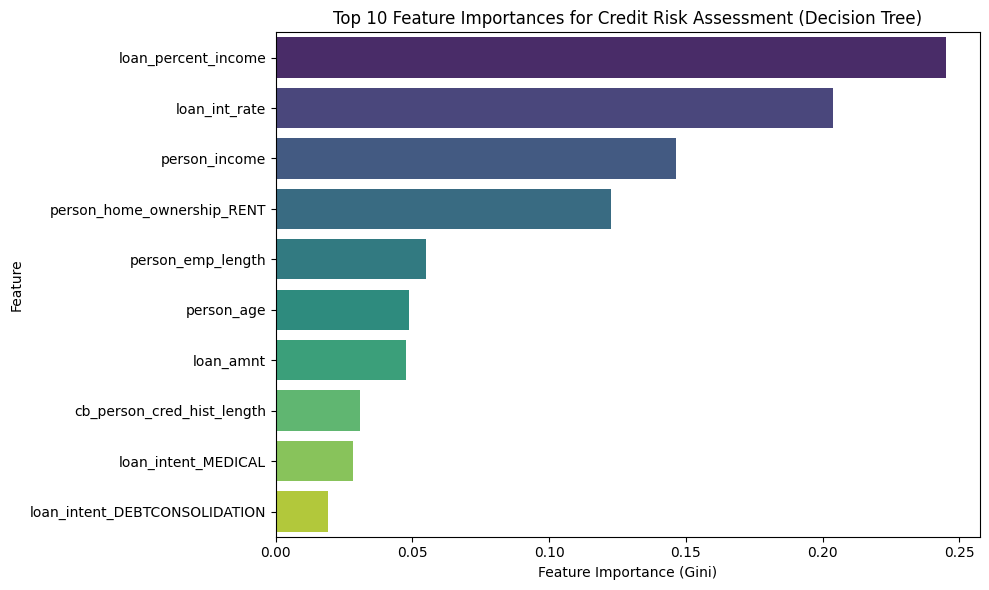

In [10]:
# Get feature names after one-hot encoding
cat_feature_names = list(model_pipeline['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features))
feature_names = numerical_features + cat_feature_names
importances = model_pipeline['classifier'].feature_importances_

# Create and sort the importance DataFrame, selecting the top 10
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# Create and save the plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Top 10 Feature Importances for Credit Risk Assessment (Decision Tree)')
plt.xlabel('Feature Importance (Gini)')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('decision_tree_feature_importance.png')

7. Predicting for previously unseen data

In [18]:
unseen_data = pd.DataFrame({
    'person_age': [35, 22],
    'person_income': [150000, 30000],
    'person_home_ownership': ['MORTGAGE', 'RENT'],
    'person_emp_length': [10.0, 0.5],
    'loan_intent': ['DEBTCONSOLIDATION', 'MEDICAL'],
    'loan_amnt': [15000, 10000],
    'loan_int_rate': [7.5, 18.0],
    'loan_percent_income': [0.10, 0.33],
    'cb_person_default_on_file': ['N', 'Y'],
    'cb_person_cred_hist_length': [15, 2]
}, index=['Applicant A', 'Applicant B'])

# Predict the loan status (0=Non-Default, 1=Default)
predictions = model_pipeline.predict(unseen_data)


# Predict the probability of default (Probability of class 1)
probabilities = model_pipeline.predict_proba(unseen_data)[:, 1]

# Combine the results
results = unseen_data.copy()
results['Predicted_Status'] = np.where(predictions == 1, 'Default (1)', 'Non-Default (0)')
results['Default_Probability'] = probabilities

results['Predicted_Status']



,Predicted_Status
Applicant A,Non-Default (0)
Applicant B,Default (1)


In [19]:
results['Default_Probability']

,Default_Probability
Applicant A,0.0
Applicant B,1.0
